In [2]:
#!pip install librosa
import os
from PIL import Image
import librosa
import glob
import time
import numpy as np
import pandas as pd
import tensorflow as tf

# image MFCC 128x44

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0
Running on TPU  ['10.83.13.66:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.83.13.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.83.13.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
dataset_path = "/content/drive/My Drive/img.pkl"
res = pd.read_pickle(dataset_path)
x = res.drop(["y"], axis=1)                     
y = res['y']
print(x.shape,y.shape)
max_data = np.max(x)
min_data = np.min(x)
data = (x-min_data)/(max_data-min_data+1e-6)
data =  data-0.5
print("Normalization done!")
x = data.to_numpy().reshape(data.shape[0],128,44,1)
y = y.to_numpy()

(52117, 5632) (52117,)
Normalization done!


In [4]:
from sklearn.model_selection import train_test_split

mode = "sequential"

if mode=="sequential":
    x = x.reshape(data.shape[0],128*44)
else:
    x = x.reshape(data.shape[0],128,44,1)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size=0.8,
                                                   shuffle=True,
                                                   random_state=8735,
                                                   stratify=y)
print("done!")

done!


In [ ]:
import matplotlib
cntTrain = np.bincount(y_train)
max = np.max(cntTrain)
res = cntTrain / max
print(res.min(),res.max(),res.mean(), res[0:5])
matplotlib.pyplot.plot([res,res+0.1])

In [ ]:
# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(shape=(60*80,)))
# model.add(keras.layers.Dense(3000, activation="relu"))
# model.add(keras.layers.Dense(50, activation="relu"))
# model.add(keras.layers.Dense(20, activation="relu"))
# model.add(keras.layers.Dense(4, activation="softmax"))

import keras
import tensorflow as tf
def getNewModel():
  model = keras.models.Sequential()
  input_shape=(x.shape[1],x.shape[2],1)
  model.add(keras.layers.Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
  model.add(keras.layers.AveragePooling2D((2, 2), strides=(2,2)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))
  model.add(keras.layers.AveragePooling2D((2, 2), strides=(2,2)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))
  model.add(keras.layers.AveragePooling2D((2, 2), strides=(2,2)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(rate=0.5))
  model.add(keras.layers.Dense(64))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dropout(rate=0.5))
  model.add(keras.layers.Dense(30))
  model.add(keras.layers.Activation('softmax'))
  return model

Using TensorFlow backend.


In [ ]:
from numpy import array
from sklearn.model_selection import KFold

# def kfoldcv(classifier):
kf = KFold(n_splits=10,shuffle=True,random_state=43)
kf.get_n_splits(x) 
scores = []
modelli = []
for train_index, test_index in kf.split(x):
    print("TRAIN:", len(train_index), "TEST:", len(test_index), end=" ")
    x_train_cv, x_test_cv = x[train_index], x[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    # clf = classifier.fit(x_train_cv,y_train_cv)
    model = getNewModel()
    model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
    model.fit(x_train_cv,  y_train_cv, epochs=65)
    s = model.evaluate(x_test_cv, y_test_cv, verbose=0)
    scores.append(s)
    modelli.append(model)
    print(s)
print(scores)

TRAIN: 46905 TEST: 5212 Epoch 1/65
46905/46905 [==============================] - 35s 744us/step - loss: 3.3952 - accuracy: 0.0390
Epoch 2/65
46905/46905 [==============================] - 34s 735us/step - loss: 3.3876 - accuracy: 0.0458
Epoch 3/65
46905/46905 [==============================] - 35s 749us/step - loss: 3.3743 - accuracy: 0.0540
Epoch 4/65
46905/46905 [==============================] - 35s 743us/step - loss: 3.3223 - accuracy: 0.0718
Epoch 5/65
46905/46905 [==============================] - 35s 751us/step - loss: 3.1561 - accuracy: 0.1052
Epoch 6/65
46905/46905 [==============================] - 35s 736us/step - loss: 2.9024 - accuracy: 0.1578
Epoch 7/65
46905/46905 [==============================] - 34s 735us/step - loss: 2.6912 - accuracy: 0.2087
Epoch 8/65
46905/46905 [==============================] - 34s 731us/step - loss: 2.5440 - accuracy: 0.2479
Epoch 9/65
46905/46905 [==============================] - 34s 720us/step - loss: 2.4296 - accuracy: 0.2794
Epoch 10/65
4

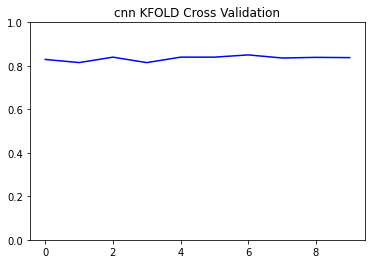

In [ ]:
sc = [s[1] for s in scores]
sc = np.array(sc)
import pickle
name = "cnn"
best_model = modelli[sc.argmax()]
filename = '/content/drive/My Drive/ModelliSalvati/Audio/Classificatori/'+name+'.sav'
pickle.dump(best_model, open(filename, 'wb'))
import matplotlib.pyplot as plt
plt.plot(sc,scaley=False,color="b")
plt.title(name+" KFOLD Cross Validation")
plt.savefig("/content/drive/My Drive/ModelliSalvati/Audio/Classificatori/"+name+".png")

In [ ]:
import tensorflow as tf
import keras 
# model = keras.models.Sequential()
# model.add(layers.Dense(1000, input_shape=(x_train.shape[1],)))
# model.add(layers.Dense(128, activation='relu '))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(30, activation='softmax'))

# model = keras.models.Sequential([
#  keras.layers.Conv2D(128,4, activation="relu", padding="same", input_shape=[x_train.shape[1],x_train.shape[2],1]),
#  keras.layers.MaxPooling2D(2),
#  keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
#  keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
#  keras.layers.MaxPooling2D(2),
#  keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
#  keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
#  keras.layers.MaxPooling2D(2),
#  keras.layers.Flatten(),
#  keras.layers.Dense(128, activation="relu"),
#  keras.layers.Dropout(0.5),
#  keras.layers.Dense(64, activation="relu"),
#  keras.layers.Dropout(0.5),
#  keras.layers.Dense(30, activation="softmax")
# ])

model = keras.models.Sequential()
input_shape=(x_train.shape[1],x_train.shape[2],1)
#1st hidden layer
model.add(keras.layers.Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
model.add(keras.layers.AveragePooling2D((2, 2), strides=(2,2)))
model.add(keras.layers.Activation('relu'))
#2nd hidden layer
model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))
model.add(keras.layers.AveragePooling2D((2, 2), strides=(2,2)))
model.add(keras.layers.Activation('relu'))
#3rd hidden layer
model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))
model.add(keras.layers.AveragePooling2D((2, 2), strides=(2,2)))
model.add(keras.layers.Activation('relu'))
#Flatten
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.5))
#Add fully connected layer.
model.add(keras.layers.Dense(64))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(rate=0.5))
#Output layer
model.add(keras.layers.Dense(30))
model.add(keras.layers.Activation('softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=35) # about 64 epoch

Train on 36481 samples, validate on 15636 samples
Epoch 1/5
36481/36481 [==============================] - 35s 953us/step - loss: 2.7755 - accuracy: 0.1882 - val_loss: 1.9900 - val_accuracy: 0.4456
Epoch 2/5
36481/36481 [==============================] - 34s 941us/step - loss: 2.0585 - accuracy: 0.3795 - val_loss: 1.4072 - val_accuracy: 0.6140
Epoch 3/5
36481/36481 [==============================] - 37s 1ms/step - loss: 1.6700 - accuracy: 0.4960 - val_loss: 1.0729 - val_accuracy: 0.6947
Epoch 4/5
36481/36481 [==============================] - 37s 1ms/step - loss: 1.4840 - accuracy: 0.5482 - val_loss: 0.9696 - val_accuracy: 0.7297
Epoch 5/5
36481/36481 [==============================] - 36s 984us/step - loss: 1.3668 - accuracy: 0.5871 - val_loss: 0.8973 - val_accuracy: 0.7452


In [ ]:
# SAVE CNN TO FS
model.save("/content/drive/My Drive/best_audio_cnn_model.h5")

In [ ]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=35) # about 64 epoch

Train on 36481 samples, validate on 15636 samples
Epoch 1/5
36481/36481 [==============================] - 36s 980us/step - loss: 0.6839 - accuracy: 0.7926 - val_loss: 0.4142 - val_accuracy: 0.8833
Epoch 2/5
36481/36481 [==============================] - 36s 983us/step - loss: 0.6799 - accuracy: 0.7923 - val_loss: 0.4068 - val_accuracy: 0.8812
Epoch 3/5
36481/36481 [==============================] - 34s 942us/step - loss: 0.6728 - accuracy: 0.7944 - val_loss: 0.4231 - val_accuracy: 0.8777
Epoch 4/5
36481/36481 [==============================] - 35s 968us/step - loss: 0.6798 - accuracy: 0.7915 - val_loss: 0.4048 - val_accuracy: 0.8821
Epoch 5/5
36470/36481 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.7942

In [ ]:
# READ CNN FROM FS
from keras.models import load_model
import h5py
model = tf.keras.models.load_model('/content/drive/My Drive/best_audio_cnn_model.h5')

In [ ]:
ynew = model.predict_classes(x_test)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test,ynew)

0.8844973138910207

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model.fit_generator, x_test, y_test)
plt.show()

In [ ]:
cm = confusion_matrix(y_test, ynew)
pd.DataFrame(cm, columns=range(30)).head(30)

In [ ]:
disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=True)
disp.ax_.set_title(title)

In [ ]:
from sklearn.metrics import classification_report
y_pred = ynew
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
models = {}
models_history = []
def save_model(name, model, persist=False):
  if name not in models:
    models[name]=[model]
  else:
    models[name].append(model)
  
  if len(models_history)>=10:
    models_history.pop(0)
  print(name + " saved!")
  
  if persist:
    print(persist)

  models_history.append((name,model))

In [ ]:
from sklearn.mixture import GaussianMixture
clf = GaussianMixture(n_components=30)
l = clf.fit(x_train,y_train)
save_model("GMM",clf.fit(x_train,y_train))

In [6]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=2).fit(x_train,y_train)
# save_model("KNN",clf.fit(x_train,y_train))

In [ ]:
y_new = clf.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
report = accuracy_score(y_test, y_new)
print(report)

0.5625479662317728


In [ ]:
# save the model to disk
import pickle
filename = '/content/drive/My Drive/ModelliSalvati/Audio/Classificatori/KNN.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
print("ciao")

ciao


In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB(fit_prior=False)
# save_model("CategoricalNB",clf.fit(x_train,y_train))

CategoricalNB saved!


In [ ]:
from sklearn.neighbors import KernelDensity
clf = KernelDensity(kernel="gaussian", bandwidth=0.5)
save_model("KernelDensity",clf.fit(x_train))

KernelDensity saved!


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=50, random_state=0, )
save_model("adaboost",clf.fit(x_train,y_train))

adaboost saved!


In [ ]:
# for m in models_history:
#   print(m[0],end=" ")
#   print(m[1].score(x_test,y_test))
print(models_history[len(models_history)-1][0])
models_history[len(models_history)-1][1].score(x_test,y_test)

adaboost


0.1612576064908722

In [ ]:
from numpy import array
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
modelli = []
def kfoldcv(classifier):
  kf = KFold(n_splits=10,shuffle=True,random_state=43)
  kf.get_n_splits(x) # RIMETTERE x PER CONSIDERARE TUTTO IL DATASET 
  scores = []
  for train_index, test_index in kf.split(x):
      print("TRAIN:", len(train_index), "TEST:", len(test_index), end=" ")
      x_train_cv, x_test_cv = x[train_index], x[test_index]
      y_train_cv, y_test_cv = y[train_index], y[test_index]
      clf = classifier.fit(x_train_cv,y_train_cv)
      s = clf.score(x_test_cv,y_test_cv)
      scores.append(s)
      modelli.append(clf)
      print(s)
  return np.array(scores),clf
clfs = [
        AdaBoostClassifier(n_estimators=50, random_state=0),
        make_pipeline(StandardScaler(), SVC(gamma='auto')),
        KNeighborsClassifier(n_neighbors=2),
        CategoricalNB(fit_prior=False),
        KernelDensity(kernel="gaussian", bandwidth=0.5)
]
scores,clf = kfoldcv(clfs[4])

TRAIN: 46905 TEST: 5212 

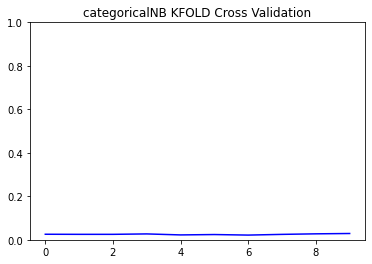

In [8]:
import matplotlib.pyplot as plt
plt.plot(scores,scaley=False,color="b")
plt.title("KernelDensity KFOLD Cross Validation")
plt.savefig("/content/drive/My Drive/ModelliSalvati/Audio/Classificatori/KernelDensity.png")
import pickle
filename = '/content/drive/My Drive/ModelliSalvati/Audio/Classificatori/KernelDensity.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
clf = SVC(gamma='auto')
clf.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
res = pd.DataFrame(data=[scores,scores-0.2])

[array([0.60019175, 0.59348035, 0.57813998, 0.59117083, 0.62955854,
        0.62092131, 0.60556622, 0.63147793, 0.61228407, 0.61708253]),
 array([0.40019175, 0.39348035, 0.37813998, 0.39117083, 0.42955854,
        0.42092131, 0.40556622, 0.43147793, 0.41228407, 0.41708253])]

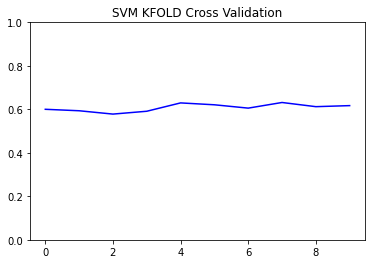

In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores,scaley=False,color="b")
plt.title("SVM KFOLD Cross Validation")
plt.savefig("/content/drive/My Drive/ModelliSalvati/Audio/Classificatori/svm.png")

In [ ]:
# save the model to disk
import pickle
filename = '/content/drive/My Drive/ModelliSalvati/Audio/Classificatori/svm.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
from numpy import array
from sklearn.model_selection import KFold

# def kfoldcv(classifier):
kf = KFold(n_splits=10,shuffle=True,random_state=43)
kf.get_n_splits(x) # RIMETTERE x PER CONSIDERARE TUTTO IL DATASET 
scores = []
for train_index, test_index in kf.split(x):
    print("TRAIN:", len(train_index), "TEST:", len(test_index), end=" ")
    x_train_cv, x_test_cv = x[train_index], x[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    # clf = classifier.fit(x_train_cv,y_train_cv)
    model = getNewModel()
    model.compile(loss="sparse_categorical_crossentropy", optimizer='sgd', metrics=['accuracy'])
    model.fit(x_train_cv,  y_train_cv, epochs=65)
    s = model.evaluate(x_test_cv, y_test_cv, verbose=0)
    scores.append(s)
    modelli.append(model)
    print(s)
print(scores)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf = clf.fit(x_train, y_train)

In [ ]:
clf.score(x_test,y_test)

In [ ]:
print("Done!")